## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## 1. Compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

        
cv2.destroyAllWindows()

In [2]:
# camera calibration from objpoints and imgpoints
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, 
                       imgpoints, img.shape[1::-1],None,None)
# define function to undistort raw images
def cal_undistort(img, mtx=mtx,dist=dist):
    undist = cv2.undistort(img, mtx, dist)
    return undist
    
# display undistored images
for fname in images:
    img = cv2.imread(fname)
    undist = cal_undistort(img)
    
    cv2.imshow('undistored', undist)
    cv2.waitKey(500)
    cv2.imwrite('messigray.png',img)
    
cv2.destroyAllWindows()
    

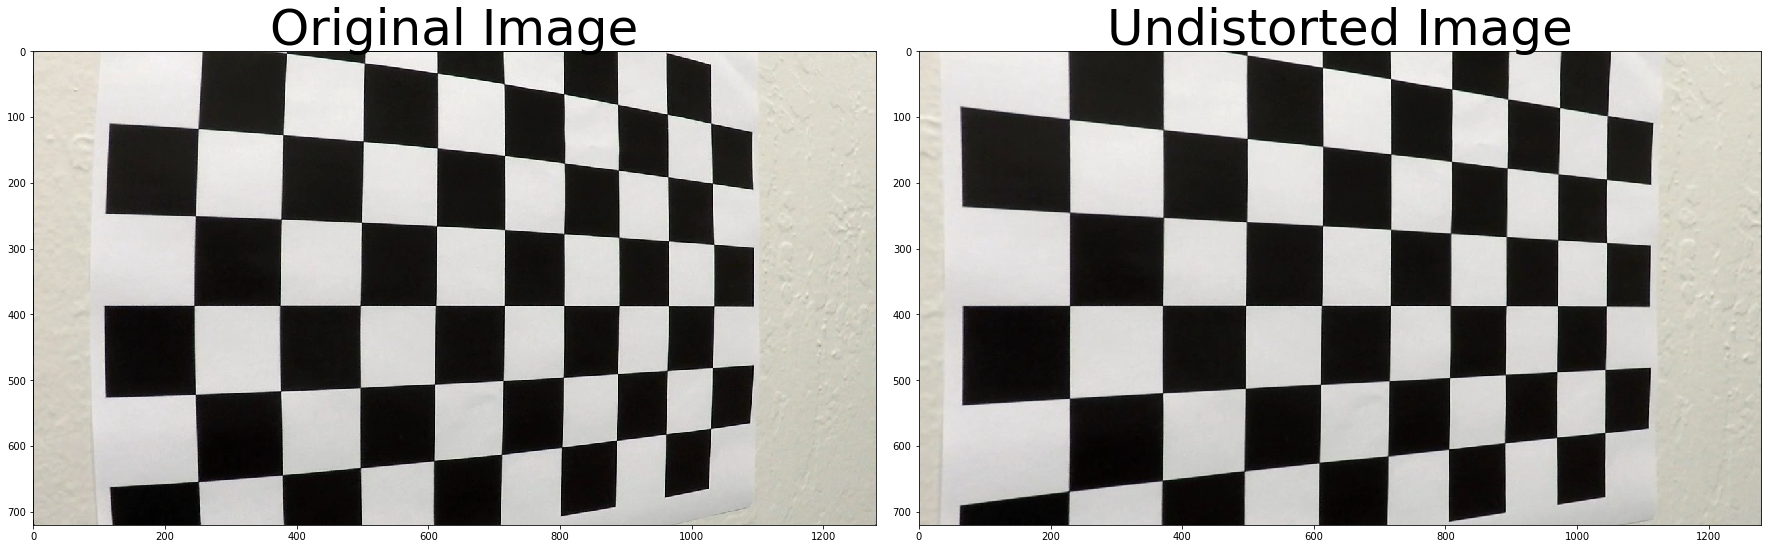

In [3]:
# comparison of one original vs undistored image as an example
img_eg = mpimg.imread(images[-5])
undist_eg = cal_undistort(img_eg)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img_eg)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undist_eg)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# save 
f.savefig('./output_images/chessbrd_raw_undist.png')

## 2. Apply a distortion correction to raw images

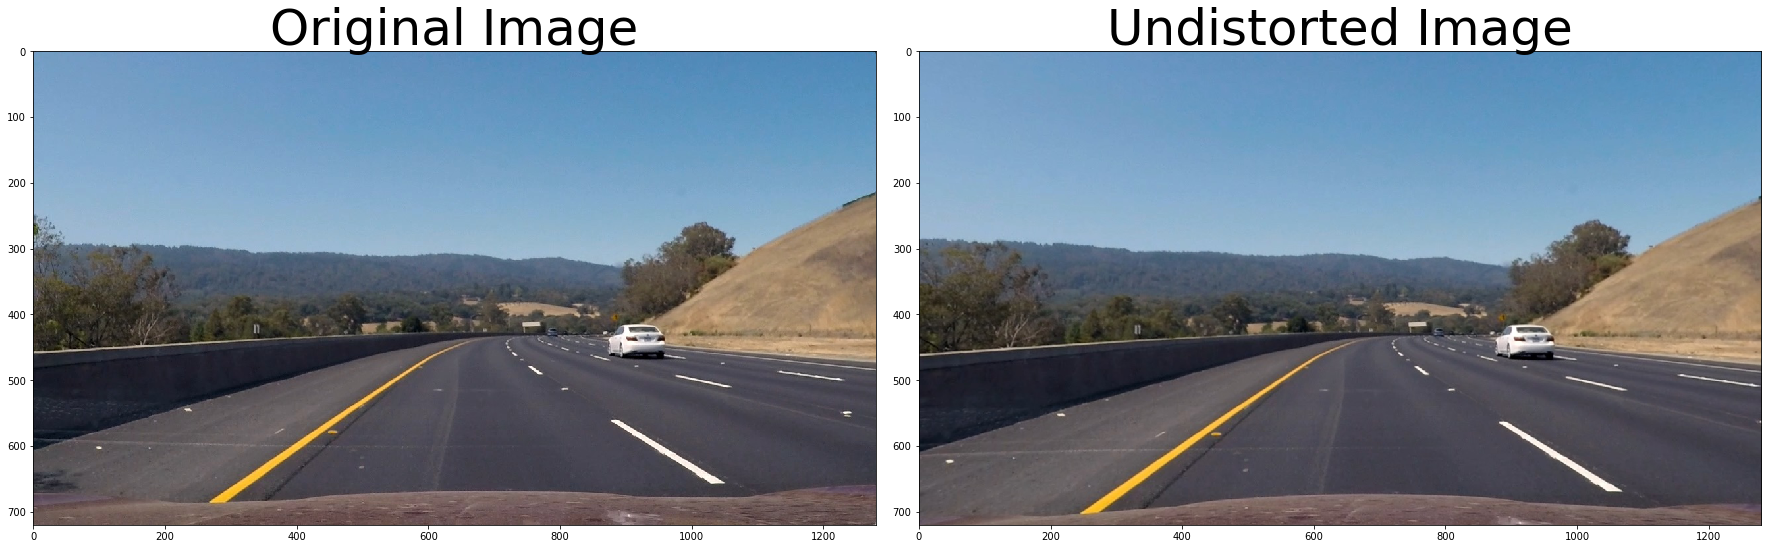

In [4]:
img_eg = mpimg.imread('./test_images/test3.jpg')
undist_eg = cal_undistort(img_eg)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img_eg)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undist_eg)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# save 
# f.savefig('./output_images/test3_raw_undist.png')

## 3. Use color transforms, gradients, etc., to create a thresholded binary image

In [5]:
# get binary images from (undistored) images with lane lines clearly shown
# by adjusting s_thresh and sx_thresh
def get_binaryImg(img, s_thresh=(150, 255), sx_thresh=(50, 100)):
    img = np.copy(img)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1    
    
    return combined_binary, sxbinary, s_binary

combined_binary, sxbinary, s_binary = get_binaryImg(undist_eg)

# Stack each channel
color_sxbinary = np.dstack(( np.zeros_like(sxbinary), sxbinary, np.zeros_like(sxbinary))) * 255
color_s_binary = np.dstack(( np.zeros_like(s_binary), np.zeros_like(s_binary), s_binary)) * 255


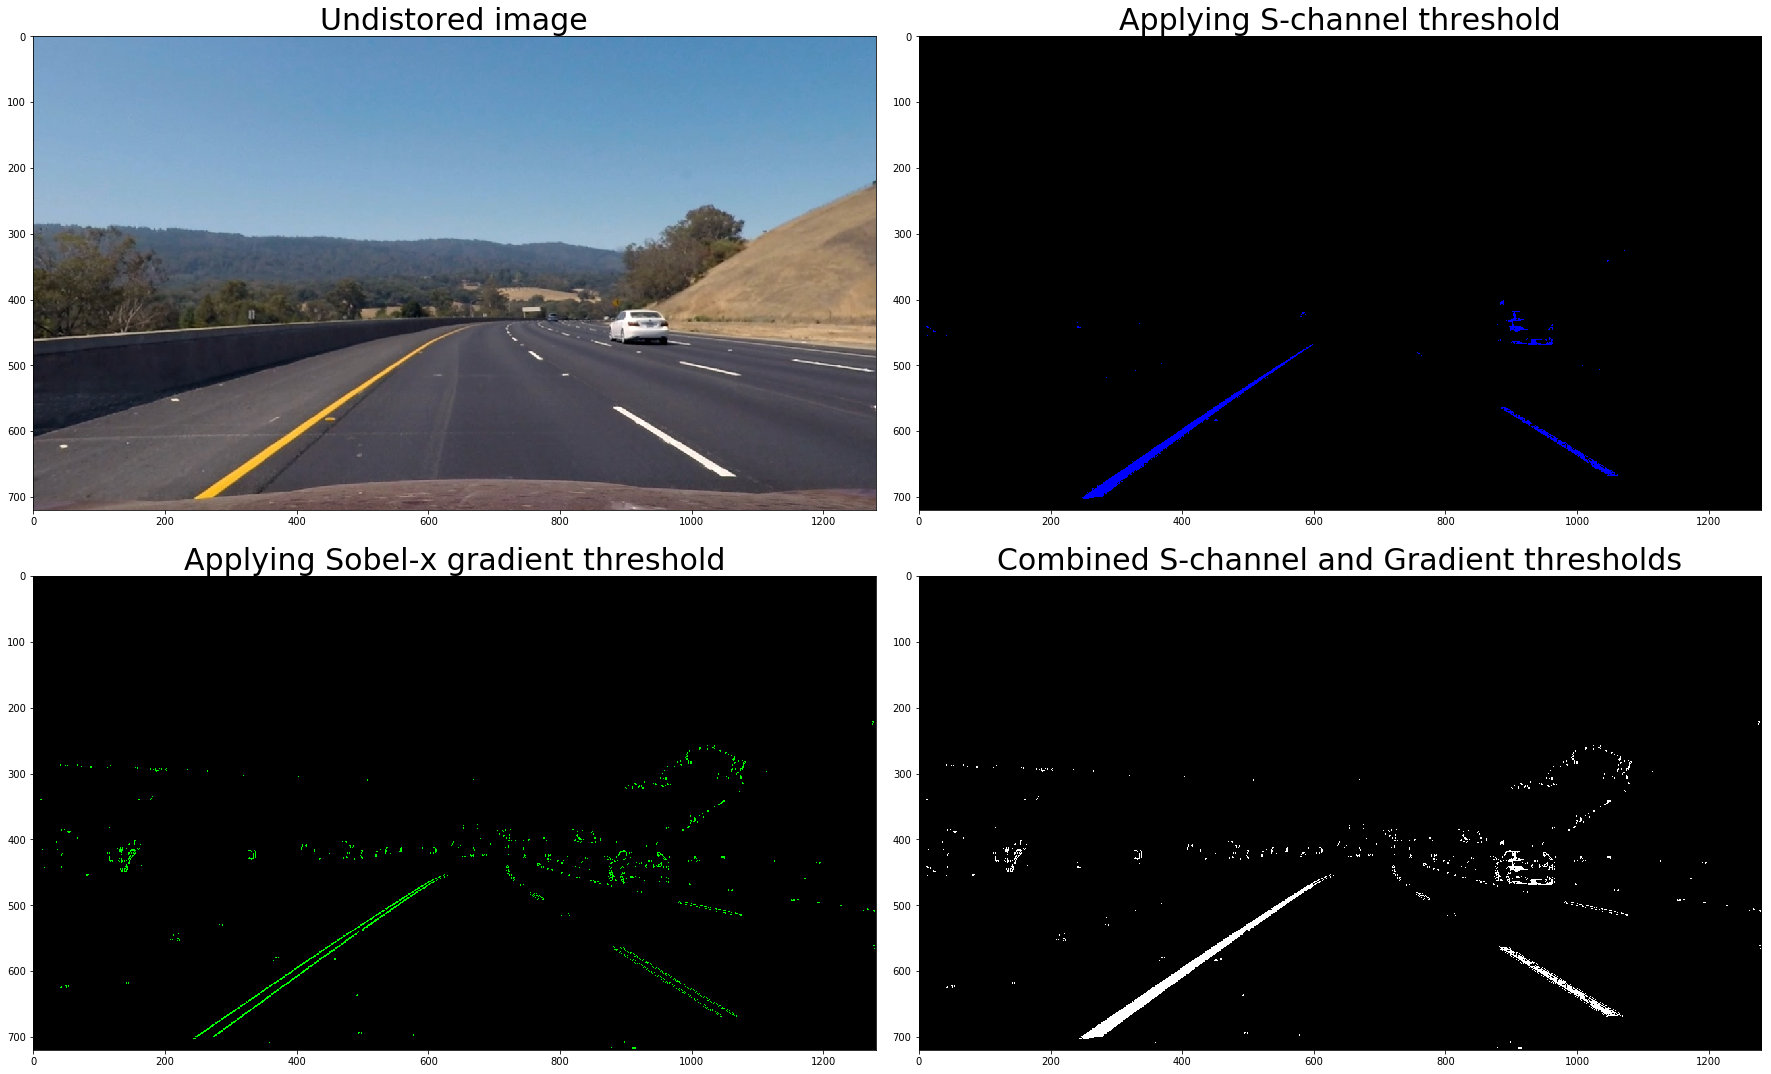

In [6]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(24, 15))
f.tight_layout()
ax1.imshow(undist_eg)
ax1.set_title('Undistored image', fontsize=30)
ax2.imshow(color_s_binary)
ax2.set_title('Applying S-channel threshold', fontsize=30)
ax3.imshow(color_sxbinary)
ax3.set_title('Applying Sobel-x gradient threshold', fontsize=30)
ax4.imshow(combined_binary, cmap='gray')
ax4.set_title('Combined S-channel and Gradient thresholds',fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.97, bottom=0.)

# save 
f.savefig('./output_images/binary.png')


## 4. Apply a perspective transform to rectify binary image ("birds-eye view")

In [49]:
img_size = (img_eg.shape[1], img_eg.shape[0])  # image size: 1280*720

src = np.float32(
    [[(img_size[0] / 2) - 62, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 25), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 66), img_size[1] / 2 + 100]])
dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])

print('src:\n', src)
print('dst:\n', dst)

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)


src:
 [[  578.           460.        ]
 [  188.33332825   720.        ]
 [ 1126.66662598   720.        ]
 [  706.           460.        ]]
dst:
 [[ 320.    0.]
 [ 320.  720.]
 [ 960.  720.]
 [ 960.    0.]]


In [50]:
def get_warpImg(img, M=M, img_size=img_size):
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped

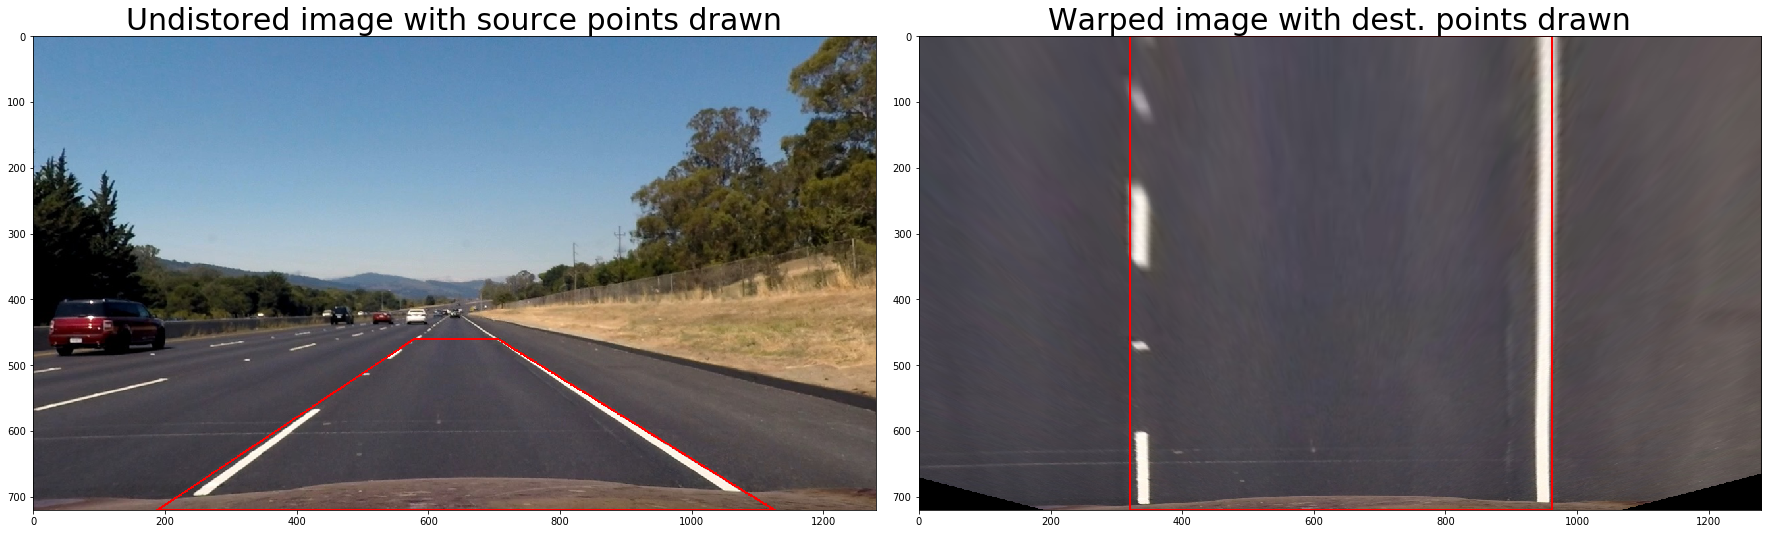

In [58]:
img_strLine = mpimg.imread('./test_images/straight_lines2.jpg')
undist_strLine = cal_undistort(img_strLine)
warped_strLine = get_warpImg(undist_strLine)
# draw source/dest points on
for i in range(4):
    j = i+1
    if j>3:
        j=0
    cv2.line(undist_strLine, tuple(src[i,:]), tuple(src[j,:]), (255,0,0), 2)
    cv2.line(warped_strLine, tuple(dst[i,:]), tuple(dst[j,:]), (255,0,0), 2)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8))
f.tight_layout()
ax1.imshow(undist_strLine)
ax1.set_title('Undistored image with source points drawn', fontsize=30)
ax2.imshow(warped_strLine)
ax2.set_title('Warped image with dest. points drawn', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.95, bottom=0.)

# save 
f.savefig('./output_images/warped2.png')

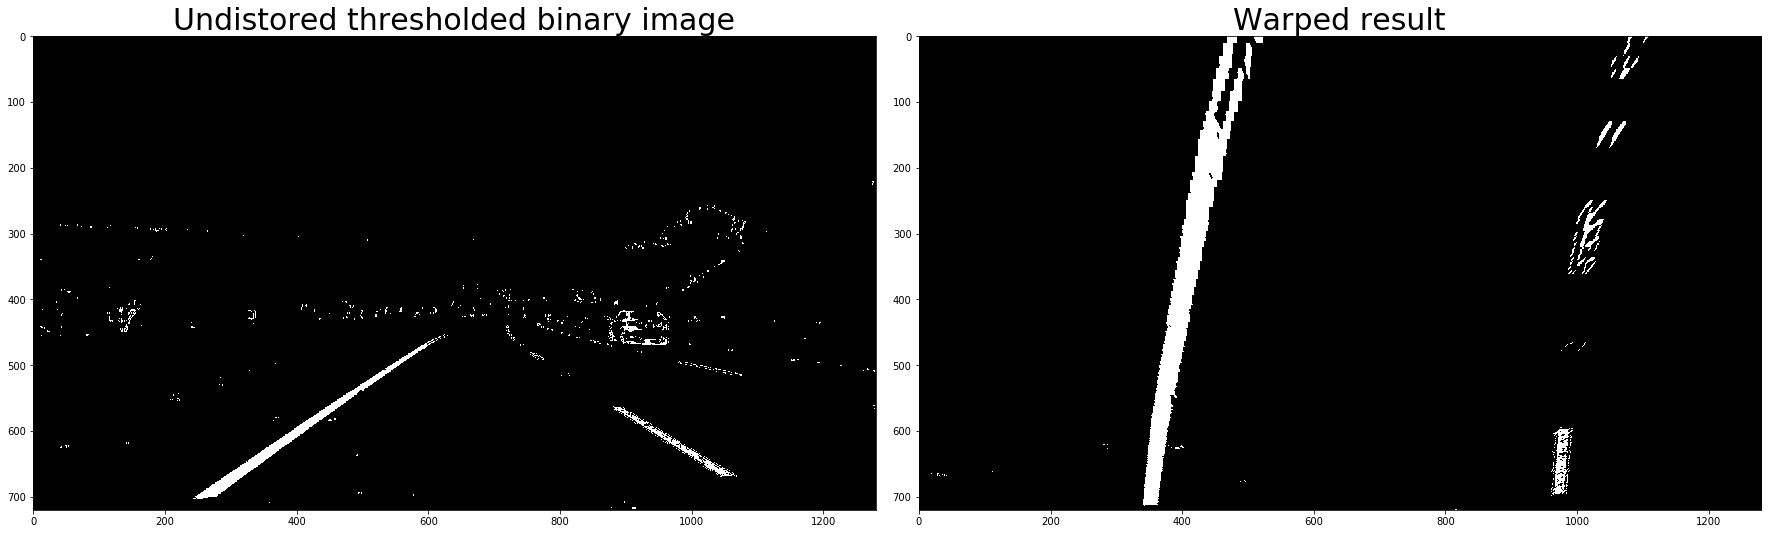

In [60]:
warped_cmbinary = get_warpImg(combined_binary)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8))
f.tight_layout()
ax1.imshow(combined_binary, cmap='gray')
ax1.set_title('Undistored thresholded binary image', fontsize=30)
ax2.imshow(warped_cmbinary, cmap='gray')
ax2.set_title('Warped result', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.95, bottom=0.)

# save 
f.savefig('./output_images/warped_cmbBinary.png')

## 5. Detect lane pixels and fit to find the lane boundary

There are two ways defined in this project to find lane pixels from the thresholded binary images. The first way utilizes sliding windows from bottom to the top while adjusting the window positions based on pixels distributions. This is used when no information of rough searching area is given, which is typical for a single image. The function using sliding windows to find lane pixels is shown below. 

In [69]:
# define function to detect lane pixels using sliding widows
# leftx, lefty, rightx, righty, out_visual = findLanePixels_slidWindow(binary_warped,nwindows=9,margin=100,mimnpix=50)
# HYPERPARAMETERS: 
#    -nwindows: number of sliding windows
#    -margin: the width of the windows +/- margin
#    -mimnpix: minimum number of pixels found to recenter window
def findLanePixels_slidWindow(binary_warped,nwindows=9,margin=100,minpix=50):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_visual = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current-margin  # Update this
        win_xleft_high = leftx_current+margin  # Update this
        win_xright_low = rightx_current-margin  # Update this
        win_xright_high = rightx_current+margin  # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_visual,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_visual,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((win_xleft_low<=nonzerox) & (nonzerox<win_xleft_high) & 
                          (win_y_low<=nonzeroy) & (nonzeroy<win_y_high)).nonzero()[0]
        good_right_inds = ((win_xright_low<=nonzerox) & (nonzerox<win_xright_high) & 
                           (win_y_low<=nonzeroy) & (nonzeroy<win_y_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window
        # (`right` or `leftx_current`) on their mean position
        if len(good_left_inds)>minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds)>minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    # Colors in the left and right lane regions
    out_visual[lefty, leftx] = [255, 0, 0]
    out_visual[righty, rightx] = [0, 0, 255]
    
    return leftx, lefty, rightx, righty, out_visual



Another way is searching lane pixels along a known polynomial curve. This method is suitable for video frames. The given polynomial curve is usually available from previous frame. The function for this method is defined below:

In [70]:

# define function to detect lane pixels with previous polynomial fit information
def findLanePixels_around_poly(binary_warped,left_fit_guess,right_fit_guess,margin=100):
    
    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    tmp_left_x = left_fit_guess[0]*nonzeroy**2+left_fit_guess[1]*nonzeroy+left_fit_guess[2]
    left_lane_inds = ((tmp_left_x-margin<nonzerox)
                        & (tmp_left_x+margin>nonzerox)).nonzero()[0]
    tmp_right_x = right_fit_guess[0]*nonzeroy**2+right_fit_guess[1]*nonzeroy+right_fit_guess[2]                   
    right_lane_inds = ((tmp_right_x-margin<nonzerox) & 
                        (tmp_right_x+margin>nonzerox)).nonzero()[0]
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
        
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
       
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    img_shape = binary_warped.shape
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    left_fitx_guess = left_fit_guess[0]*ploty**2+left_fit_guess[1]*ploty+left_fit_guess[2]
    right_fitx_guess = right_fit_guess[0]*ploty**2+right_fit_guess[1]*ploty+right_fit_guess[2]    
    
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx_guess-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx_guess+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx_guess-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx_guess+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    out_visual = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    
    return leftx, lefty, rightx, righty, out_visual

The code below shows the lane pixels found using sliding windows for the warped binary image shown in Section 4. Lane pixels for the left lane are represented in red color while the ones for the right lane in blue. A second-order polynomial fit is made with regard to these given lane pixels. The fitted polynomial curves for left and right lanes are also shown on the image. 

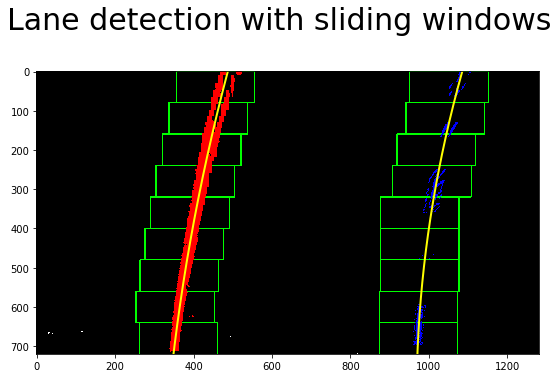

In [105]:
leftx, lefty, rightx, righty, out_visual = findLanePixels_slidWindow(warped_cmbinary)

# fitted polynomial coefficients
left_coef = np.polyfit(lefty,leftx,2)
right_coef = np.polyfit(righty,rightx,2)

def polyval(img_shape,poly_coef):
    yin = np.linspace(0, img_shape[0]-1, img_shape[0])
    xin = poly_coef[0]*yin**2+poly_coef[1]*yin+poly_coef[2]
    return xin, yin

left_xin, left_yin = polyval(warped_cmbinary.shape,left_coef)
right_xin, right_yin = polyval(warped_cmbinary.shape,right_coef)

f = plt.figure(figsize=(9, 6))
plt.plot(left_xin, left_yin, color='yellow',linewidth=2)
plt.plot(right_xin, right_yin, color='yellow',linewidth=2)
plt.imshow(out_visual)
f.suptitle('Lane detection with sliding windows', fontsize=30)

f.savefig('./output_images/lanePixels_slidwindow.png')


In [106]:
print(left_coef)
print(right_coef)

[  1.00357818e-04  -2.64438619e-01   4.87344991e+02]
[  1.68402657e-04  -2.79864318e-01   1.08488915e+03]


The code below tests the second way to find the lane pixels when a rough search area is known around given polynomial curves (for videos usually from previous frame). 

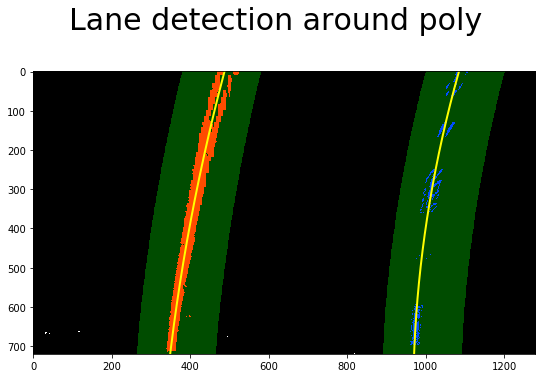

In [107]:
left_coef_prvs = np.array([ 1.1e-04,  -2.4e-01,   4.8e+02])
right_coef_prvs = np.array([1.5e-04, -2.6e-01,   1.1e+03])

leftx, lefty, rightx, righty, out_visual = findLanePixels_around_poly(warped_cmbinary,left_coef_prvs,right_coef_prvs)

# fitted polynomial coefficients
left_coef = np.polyfit(lefty,leftx,2)
right_coef = np.polyfit(righty,rightx,2)

left_xin, left_yin = polyval(warped_cmbinary.shape,left_coef)
right_xin, right_yin = polyval(warped_cmbinary.shape,right_coef)

f = plt.figure(figsize=(9, 6))
plt.plot(left_xin, left_yin, color='yellow',linewidth=2)
plt.plot(right_xin, right_yin, color='yellow',linewidth=2)
plt.imshow(out_visual)
f.suptitle('Lane detection around poly', fontsize=30)

f.savefig('./output_images/lanePixels_aroundPoly.png')

In [108]:
print(left_coef)
print(right_coef)

[  1.00357818e-04  -2.64438619e-01   4.87344991e+02]
[  1.68402657e-04  -2.79864318e-01   1.08488915e+03]


It can be seen both ways if utilized properly could find lane pixels from the binary images and obtain similar polynomial coefficients for left and right lane. 

## 6. Determine the curvature of the lane and vehicle position with respect to center

Define the function to calculate curvature with the scale information from pixel to meters.

In [115]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/640 # meters per pixel in x dimension

def cvtCoef_pix2real(coef_pix, xm_per_pix,ym_per_pix):
    coef_real = np.zeros_like(coef_pix)
    coef_real[0] = coef_pix[0]*xm_per_pix/(ym_per_pix**2)
    coef_real[1] = coef_pix[1]*xm_per_pix/ym_per_pix
    coef_real[2] = coef_pix[2]*xm_per_pix
    
    return coef_real

def measrCurv_real(img_shape,left_coef,right_coef,xm_per_pix,ym_per_pix):
    # conversion of left_coef, right_coef to real 
    left_coef_real = cvtCoef_pix2real(left_coef,xm_per_pix,ym_per_pix)
    right_coef_real = cvtCoef_pix2real(right_coef,xm_per_pix,ym_per_pix)
    
    y_eval = img_shape[0]-1;
    
    left_curverad = ((1+(2*left_coef_real[0]*y_eval*ym_per_pix+left_coef_real[1])**2)**1.5)/np.absolute(2*left_coef_real[0])
    right_curverad = ((1+(2*right_coef_real[0]*y_eval*ym_per_pix+right_coef_real[1])**2)**1.5)/np.absolute(2*right_coef_real[0])
    
    curv = (left_curverad+right_curverad)/2
    return curv



Define the function to calculate the offset of the vehicle from the lane center. The camera is assumed mounted at the center of the car, such that the lane center is the midpoint at the bottom of the image between the two lines we've detected. The offset of the lane center from the center of the image (converted from pixels to meters) is the distance from the center of the lane. 


In [116]:
def measrLaneOffset(img_shape, left_coef,right_coef,xm_per_pix):
    yin = img_shape[0]-1
    xin_left = left_coef[0]*yin**2+left_coef[1]*yin+left_coef[2]
    xin_right = right_coef[0]*yin**2+right_coef[1]*yin+right_coef[2]
    
    offset_pix = img_shape[1]/2.-(xin_left+xin_right)/2.
    offset = offset_pix*xm_per_pix
    return offset
    

Take the processing result from Section 5 as an example, check its curvature and offset from centerline.

In [117]:
curv = measrCurv_real(warped_cmbinary.shape,left_coef,right_coef,xm_per_pix,ym_per_pix)
print(curv)

1194.21099498


In [118]:
offset = measrLaneOffset(warped_cmbinary.shape, left_coef,right_coef,xm_per_pix)
print(offset)

-0.115101820921


## 7. Warp the detected lane boundaries back onto the original image

Define function to unwarp the lane boundaries back onto the original image. 

In [152]:
def unwarp(warped_binary,undist,left_coef,right_coef,Minv):
    warp = np.zeros_like(warped_binary)
    color_warp = np.dstack((warp,warp,warp))
    
    left_xin, left_yin = polyval(out_visual.shape[0:1],left_coef)
    right_xin, right_yin = polyval(out_visual.shape[0:1],right_coef)
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_xin, left_yin]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_xin, right_yin])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,0), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,0,255), thickness=15)
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    unwarp_undist = cv2.addWeighted(undist, 1, newwarp, .5, 0)
    
    return unwarp_undist

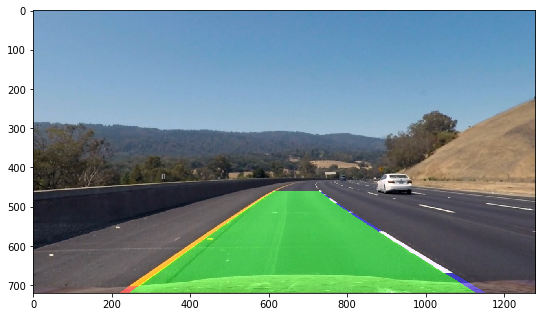

In [153]:
unwarp_undist = unwarp(warped_cmbinary,undist_eg,left_coef,right_coef,Minv)
plt.figure(figsize=(9, 6))
plt.imshow(unwarp_undist)

## 8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position

In [154]:
def display_info(orig_img, curv, offset):
    new_img = np.copy(orig_img)
    h = new_img.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX 
    text = 'Curve radius: ' + '{:04.2f}'.format(curv) + 'm'
    cv2.putText(new_img, text, (40,70), font, 1.3, (255,255,255), 2, cv2.LINE_AA)
    direction = ''
    if offset > 0:
        direction = 'right'
    elif offset < 0:
        direction = 'left'
    abs_offset = abs(offset)
    text = 'Vehicle is {:04.3f}'.format(abs_offset) + 'm ' + direction + ' of center'
    cv2.putText(new_img, text, (40,120), font, 1.3, (255,255,255), 2, cv2.LINE_AA)
    return new_img

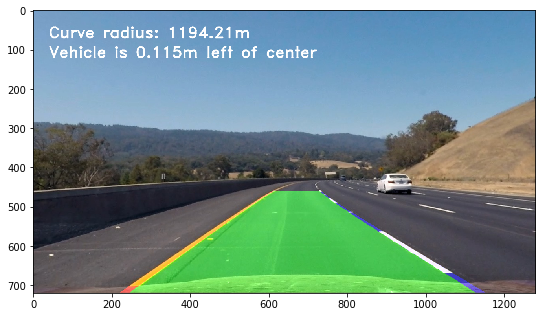

In [155]:
unwarp_undist_text = display_info(unwarp_undist, curv, offset)

f = plt.figure(figsize=(9, 6))
plt.imshow(unwarp_undist_text)
f.savefig('./output_images/unwarp_undist_text.png')

## 9. Pipeline for video